In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [27]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [28]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [29]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [30]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [33]:
#Use inspector to get column data
inspector = inspect(engine)
inspector.get_table_names()
print('measurement')
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

print(" ")    
print("station")
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
 
station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [34]:
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

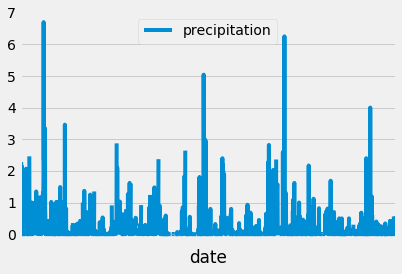

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#Would just use dt to find today and subtract 365 days if there was data available
yearback = dt.date(2017,8,23) - dt.timedelta(days = 365)
precip_data = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date >= f'{yearback}')
all_data = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date > f'{yearback}').all()
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

precip_data_df = pd.DataFrame(precip_data)
precip_data_sorted = precip_data_df.sort_values(by='date')
precip_data_sorted = precip_data_sorted.set_index('date')
precip_data_sorted.columns = ['precipitation']
# Use Pandas Plotting with Matplotlib to plot the data

precip_data_sorted.plot(xticks=[])

# Calculate the date 1 year ago from the last data point in the database

In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [38]:
# Design a query to show how many stations are available in this dataset?
M_Stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(f' There are {M_Stations} stations which reported data during this time')

 There are 9 stations which reported data during this time


In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?

station_list = []
station_count = []

# List the stations and the counts in descending order.
Stations_C = session.query(Measurement.station).group_by(Measurement.station).all()

#Create list of stations
for stations in Stations_C:
    station_list.append(stations)
    
#Convert list of tuples to list of strings
station_list = [i[0] for i in station_list]
station_list

#get reading count for each station
for stations in station_list:
    station_counts = session.query(Measurement.station).filter(Measurement.station == f'{stations}')
    station_count.append(station_counts.count())
    
#combine data into a df and sort largest to smallest
station_dict = {'station':station_list}
count_dict = {'count':station_count}
station_count_df = pd.DataFrame(station_dict)
station_count_df['count'] = station_count
station_count_df = station_count_df.sort_values(by = 'count', ascending=False)
station_count_df = station_count_df.reset_index(drop=True)
station_count_df

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [40]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_data =session.query(Measurement.tobs).filter(Measurement.station == station_count_df['station'][0]).all()
temp_data = [i[0] for i in temp_data]
print(f" The maximum Temperature reported from station {station_count_df['station'][0]} is {round(max(temp_data))}F")
print(f" The minimum Temperature reported from station {station_count_df['station'][0]} is {round(min(temp_data))}F")
print(f" The average Temperature reported from station {station_count_df['station'][0]} is {round(sum(temp_data)/len(temp_data))}F")


 The maximum Temperature reported from station USC00519281 is 85F
 The minimum Temperature reported from station USC00519281 is 54F
 The average Temperature reported from station USC00519281 is 72F


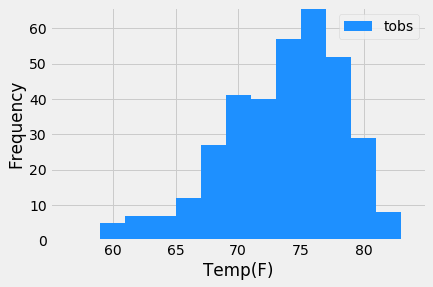

In [41]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

hist_data = (session.query(Measurement.tobs).filter(Measurement.station == station_count_df['station'][0]).filter(Measurement.date > yearback).all())


n, bins, patches = plt.hist(hist_data, bins=12, density=False, facecolor='dodgerblue', alpha=1, histtype='barstacked')

plt.xlim(55,85)
plt.ylabel('Frequency')
plt.xlabel('Temp(F)')
plt.xticks([60,65,70,75,80])
plt.legend(['tobs'])

In [44]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [45]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-08-19','2017-08-23'))

[(71.0, 79.61111111111111, 85.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [43]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
